### J-Quants API トークン取得

In [2]:
import requests
import json
#jquantsに登録してメルアドとパスワード入れます
data={"mailaddress":"addr", "password":"pass"}
r_post = requests.post("https://api.jquants.com/v1/token/auth_user", data=json.dumps(data))
refreshToken = r_post.json()["refreshToken"]

REFRESH_TOKEN = refreshToken
r_post = requests.post(f"https://api.jquants.com/v1/token/auth_refresh?refreshtoken={REFRESH_TOKEN}")
idToken = r_post.json()["idToken"]

### 上場銘柄一覧(/listed/info)から各セクターに属する銘柄を１つ選び日次データを取得
サンプルで１個ずつSector17CodeName別で計１７銘柄とした

In [5]:
import requests
import json
import pandas as pd

headers = {'Authorization': 'Bearer {}'.format(idToken)}
r = requests.get("https://api.jquants.com/v1/listed/info", headers=headers)
df_listed_info = pd.json_normalize(r.json()['info'])

In [7]:
import time

headers = {'Authorization': 'Bearer {}'.format(idToken)}
#分析したい時系列の期間
start = "20210330"
end   = "20230228"
# 各Sector17CodeNameに属するCodeを1つ選択
unique_sectors = df_listed_info["Sector17CodeName"].unique()

num_row=0
for sector in unique_sectors:
    sample_code = df_listed_info[df_listed_info["Sector17CodeName"] == sector]["Code"].sample(n=1).values[0]
    # APIリクエスト
    r = requests.get(f"https://api.jquants.com/v1/prices/daily_quotes?code={sample_code}&from={start}&to={end}", headers=headers)
    # 取得したデータをDataFrameに変換
    df_sample_stock = pd.json_normalize(r.json()['daily_quotes'])
    # df_stockにコンカチ
    if num_row == 0:
        df_stock = df_sample_stock
    else:
        df_stock = pd.concat([df_stock, df_sample_stock], ignore_index=True)
    num_row+=1
    #スリープ
    time.sleep(1)

In [34]:
# Codeをキーにして結合
merged_df = pd.merge(df_stock, df_listed_info.drop('Date',axis=1), on='Code')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])# 月ごとにデータをグループ化し、騰落率を計算
#月次収益
monthly_returns = merged_df.groupby(['Sector17CodeName', pd.Grouper(key='Date', freq='M')]).apply(lambda x: (x['AdjustmentClose'].iloc[-1] - x['AdjustmentClose'].iloc[0]) / x['AdjustmentClose'].iloc[0] * 100)

In [35]:
monthly_returns=monthly_returns.unstack()
#並びがいまいちなのでソート
monthly_returns = monthly_returns.sort_index(ascending=False)

### 月次収益ヒートマップ

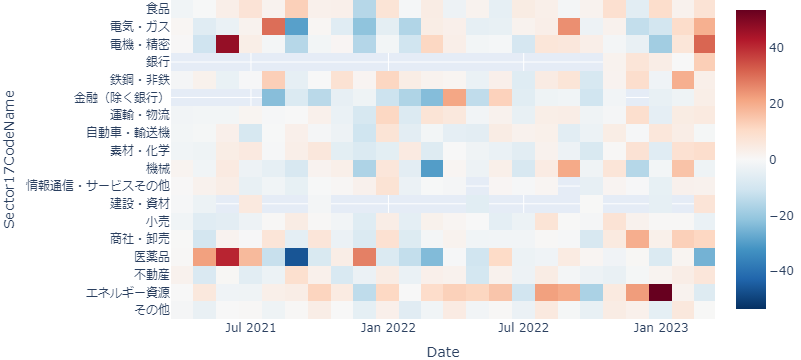

In [44]:
import plotly.express as px

fig = px.imshow(monthly_returns.round(2),color_continuous_scale='RdBu_r',color_continuous_midpoint=0)
fig.update_layout(width=1000,margin={'l': 20, 'r': 20, 't': 0, 'b': 0})
fig.show()

### 月次収益業種別相関

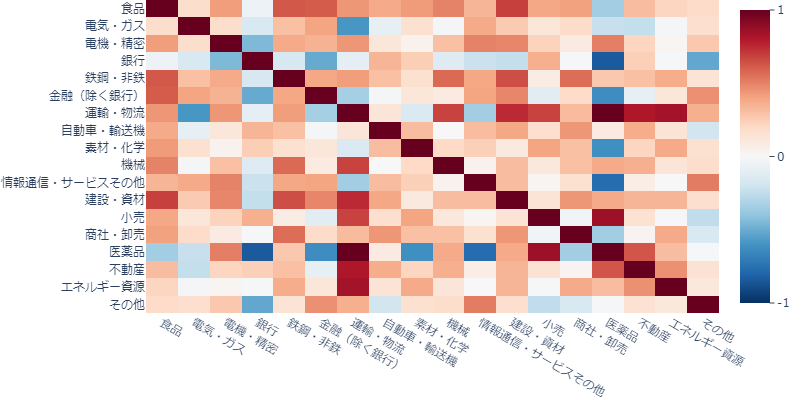

In [43]:
import plotly.graph_objects as go

df_corr=monthly_returns.T.corr().sort_index(ascending=False)
df_corr=df_corr.sort_index(axis='columns',ascending=True)
fig_corr = go.Figure([go.Heatmap(z=df_corr.round(2).values,
                                x=df_corr.round(2).index.values,
                                y=df_corr.round(2).columns.values,
                                colorscale='RdBu_r',
                                zmin = -1,
                                zmax = 1,
                                colorbar=dict(
                                    tickmode='array',
                                    tickvals=[-1,0,1],
                                    ticktext=[-1,0,1],
                                    ticks='outside'
                                ))])

fig_corr.update_layout(height=400, width=800,margin={'l': 20, 'r': 20, 't': 0, 'b': 0})

### Chat-GPT(AzureOpenAI) Google検索
google-api-python-clientやlangchainは別途インストール要
langchain ver 0.0.142

In [11]:
from langchain.chat_models import AzureChatOpenAI
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.memory import ConversationBufferMemory
import os
初期化設定
DEPLOYMENT_NAME_gpt35  = 'DEPLOYMENT_NAME'
MODEL_NAME_gpt35       = 'MODEL_NAME'
OPEN_API_VERSION_gpt35 = 'OPEN_API_VERSION'
#Azure OpenAIのパラメータ(Azureで別途設定)
os.environ["OPENAI_API_TYPE"] = 'OPENAI_API_TYPE'
os.environ["OPENAI_API_BASE"] = 'OPENAI_API_BASE' 
os.environ["OPENAI_API_KEY"]  = 'OPENAI_API_KEY'
#google_のCustime Search APIkey
os.environ["GOOGLE_CSE_ID"]  = "CSE_ID"
os.environ["GOOGLE_API_KEY"] = "GOOGLE_API_KEY

In [12]:
llm   = AzureChatOpenAI(openai_api_version=OPEN_API_VERSION_gpt35,deployment_name=DEPLOYMENT_NAME_gpt35,temperature=0)
tools = load_tools(["google-search"])
agent = initialize_agent(tools, llm, agent="zero-shot-react-description")

In [15]:
conversation_history = ""
prefix = """Anser the following questions as best you can, but speaking Japanese. You have access to the following tools:"""
suffix = """Begin! Remember to speak Japanese when giving your final answer. Use lots of "Args"""
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent_chain = initialize_agent(tools, llm, agent="chat-conversational-react-description", memory=memory, prefix=prefix, suffix=suffix)

In [17]:
# ChatGPT会話ループ
user = ""
while user != "exit":
    user = input("質問を入力（終了：exit)  ")
    print(user)
    ai = agent_chain.run(input=user)
    print(ai)

質問を入力（終了：exit)   なぜ2021年１１月は全業種で株価がさがったのか


なぜ2021年１１月は全業種で株価がさがったのか
株価が下落した理由については、人工知能（AI）分野の急成長期待で高騰していたハイテク株中心のナスダック総合株価指数が1.3%安で終えたことが一因とされています。また、半導体不足や新型コロナウイルスの感染拡大などの要因も影響していると考えられています。


質問を入力（終了：exit)   exit


exit
Goodbye!
